## Installing packages
* pip install lightgbm
* conda install -c conda-forge xgboost
* pip install xgboost

## **Stack OverFlow: EDA & ML**  

**Elijah Zolduoarrati**  
**Approaches and Techniques:**

* EDA with Pandas and Seaborn
* Find features with strong correlation to target variables questions and answers
* Data preprocessing, converting categorical features mainly (country) to numerical
* apply the basic Regression models of sklearn 
* use gridsearchCV to find the best parameters for each model
* compare the performance of the Regressors and choose best one

**The notebook is organized as follows:**

* **[Part 0: Imports, Settings and switches, Global functions](#Part-0-:-Imports,-Settings,-Functions)**  
* import libraries  
* settings for number of cross validations  
* define functions that are used often

* **[Part 1: Exploratory Data Analysis](#Part-1:-Exploratory-Data-Analysis)**  
1.1 Get an overview of the features (numerical and categorical) and first look on the target variables questions and answers
[shape, info, head and describe](#shape,-info,-head-and-describe)  
[Distribution of the target variable Q](#The-target-variable-:-Distribution-of-questions-and-answers)  
[Numerical and Categorical features](#Numerical-and-Categorical-features)  
[List of features with missing values](#List-of-features-with-missing-values) and Filling missing values using [log transform](#log-transform)  
1.2 Relation of all features to target questions and answers  
[Seaborn regression plots for numerical features](#Plots-of-relation-to-target-for-all-numerical-features)  
[List of numerical features and their correlation coefficient to target](#List-of-numerical-features-and-their-correlation-coefficient-to-target)  
[Seaborn boxplots for categorical features](#Relation-to-questions-and-answers-for-all-categorical-features)  
[List of categorical features and their unique values](#List-of-categorical-features-and-their-unique-values)  
1.3 Determine the columns that show strong correlation to target  
[Correlation matrix 1](#Correlation-matrix-1) : all numerical features determine features with largest correlation to questions and answers

* **[Part 2: Data wrangling](#Part-2:-Data-wrangling)**  
[Dropping all columns with weak correlation to questions and answers](#Dropping-all-columns-with-weak-correlation-to-questions-and-answers)  
[Convert categorical columns to numerical](#Convert-categorical-columns-to-numerical)  
[Checking correlation to SalePrice for the new numerical columns](#Checking-correlation-to-questions-and-answers-for-the-new-numerical-columns)  
use only features with strong correlation to target  
[Correlation Matrix 2 (including converted categorical columns)](#Correlation-Matrix-2-:-All-features-with-strong-correlation-to-questions-and-answers)  
Create datasets for ML algorithms:                                                                          
[OneHotEncoder](#OneHotEncoder)  
[StandardScaler](#StandardScaler)

* **[Part 3: Scikit-learn basic regression models and comparison of results](#Part-3:-Scikit-learn-basic-regression-models-and-comparison-of-results)**  
implement GridsearchCV with RMSE metric for Hyperparameter tuning for these models from sklearn:  
[Linear Regression](#Linear-Regression)  
[Ridge](#Ridge)  
[Lasso](#Lasso)  
[Elastic Net](#Elastic-Net)  
[Stochastic Gradient Descent](#SGDRegressor)  
[DecisionTreeRegressor](#DecisionTreeRegressor)  
[Random Forest Regressor](#RandomForestRegressor)  
[KNN Regressor](#KNN-Regressor)  
Baed on RMSE metric, compare performance of the regressors with their optimized parameters, then explore correlation of the predictions and make submission with mean of best models plot comparison:             
[RMSE of all models](#Comparison-plot:-RMSE-of-all-models)  
[Correlation of model results](#Correlation-of-model-results)  
Mean of best models


Note on scores:  
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed questions and answers. (Taking logs means that errors in predicting questions and answers will affect the result equally.)

# Part 0 : Imports, Settings, Functions

In [1]:
#Visualizing Lib
import seaborn as sns
import matplotlib.pyplot as plt

#Math Lib for some statistics
from scipy import stats
%matplotlib inline
sns.set()

# df preprocessing Lib
import pandas as pd
import numpy as np
pd.set_option('max_columns', 105)

# AI preprocessing lib
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split 

# ML Lib
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import sklearn.linear_model as linear_model
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

# warning supressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")
#importing necessary models and libraries

**Settings and switches**

**Here we can choose settings for optimal performance and runtime. For example, nr_cv sets the number of cross validations used in GridsearchCV, and min_val_corr is the minimum value for the correlation coefficient to the target (only features with larger correlation will be used).** 

In [2]:
# setting the number of cross validations used in the Model part 
nr_cv = 5

# switch for using log values for SalePrice and features     
use_logvals = 1    
# target used for correlation 
target_1 = 'questions'
target_2 = 'answers'    
# only columns with correlation above this threshold value  
# are used for the ML Regressors in Part 3
min_val_corr = 0.4    
    
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

**Initiate functions:**

In [3]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    return best_score

def print_cols_large_corr(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])

def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

In [4]:
from subprocess import check_output, call 
print(check_output(["dir", "C:\\Users\\alamo248\\Downloads\\Data\\all_uptt.csv"],shell=True).decode("utf8"))

 Volume in drive C is Windows
 Volume Serial Number is 5843-B50F

 Directory of C:\Users\alamo248\Downloads\Data

10/12/2019  04:07 PM           191,469 all_uptt.csv
               1 File(s)        191,469 bytes
               0 Dir(s)  360,699,768,832 bytes free



In [5]:
#Importing data into dataframe
df =  pd.read_csv('C://Data/all_upt.csv')

In [6]:
#Displaying dataframe
df.head()

,Id,AboutMe,CreationDate,LastAccessDate,DisplayName,Location,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers
0,7784035,<p>This product may also help you to feel full...,2017-03-29 06:30:11.463 UTC,2017-03-29 06:30:11.463 UTC,berwenally,New York,usa,1407.0,0.0,0,0,1,2,1,10.0,11.0,12.0,13.0
1,9126518,<p>A simple way to keep your hands moisturized...,2017-12-21 10:07:00.237 UTC,2017-12-21 10:07:00.237 UTC,TeresaEWilliams,United States,usa,622.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0
2,10021482,<p>Completely covers and protects your body pi...,2018-07-02 12:09:47.843 UTC,2018-07-02 13:30:11.797 UTC,kimberly02,Fremont,usa,370.0,0.0,0,0,1,1,1,NaN,NaN,0.0,0.0
3,2739419,<p>POOL TABLES FOR SALE CONTEMPORARY CLASSIC C...,2013-09-02 10:00:27.57 UTC,2013-09-02 10:00:27.57 UTC,USA Made Pool Tables,California,usa,400.0,0.0,0,0,1,1,1,NaN,NaN,0.0,0.0
4,1440631,<p>I am a Software Engineer</p>\n,2012-06-06 19:21:00.903 UTC,2012-06-06 19:36:13.78 UTC,twinkle,United States,usa,32.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0


In [7]:
# subtitute missing values by zero
#df = df.fillna(0)
#Displaying modified dataframe
#df.head()

In [8]:
## creating a variable vector
df = df.iloc[:,[0,6,7,8,9,10,11,12,13,14,15,16,17]]
# Or
# vec = df.loc[:,['Id','DisplayName','Location','country','AboutMe_length','activity_in_months','UpVotes','DownVotes','Reputation','Views','badges','Q_comments','A_comments','P_questions','P_answers']]

In [9]:
df.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers
0,7784035,usa,1407.0,0.0,0,0,1,2,1,10.0,11.0,12.0,13.0
1,9126518,usa,622.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0
2,10021482,usa,370.0,0.0,0,0,1,1,1,NaN,NaN,0.0,0.0
3,2739419,usa,400.0,0.0,0,0,1,1,1,NaN,NaN,0.0,0.0
4,1440631,usa,32.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0


In [10]:
# Create training and testing sets
df_train,df_test= train_test_split(df, test_size = 0.2, random_state = 0)

# Part 1: Exploratory Data Analysis

## 1.1 Overview of features and relation to target

Let's get a first overview of the train and test dataset
* How many rows and columns are there?  
* What are the names of the features (columns)?  
* Which features are numerical, which are categorical?  
* How many values are missing?  
The **shape** and **info** methods answer these questions. Whereas, the **head** displays some rows of the dataset **describe** gives a summary of the statistics (only for numerical columns)

### Shape, Info, Head & Describe -----> Functions

In [11]:
print('-'*100)
print('training sample size')
print(df_train.shape)
print('-'*100)
print('testing sample size')
print(df_test.shape)
print('-'*100)
print('training sample features description')
print(df_train.info())
print('-'*100)
print('testing sample features description')
print(df_train.info())
print('-'*100)

----------------------------------------------------------------------------------------------------
training sample size
(112147, 13)
----------------------------------------------------------------------------------------------------
testing sample size
(28037, 13)
----------------------------------------------------------------------------------------------------
training sample features description
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112147 entries, 8441 to 43567
Data columns (total 13 columns):
Id                    112147 non-null int64
country               112147 non-null object
AboutMe_length        72567 non-null float64
activity_in_months    112147 non-null float64
UpVotes               112147 non-null int64
DownVotes             112147 non-null int64
Reputation            112147 non-null int64
Views                 112147 non-null int64
badges                112147 non-null int64
Q_comments            29880 non-null float64
A_comments            29880 non-null

* It seems like the trainning and tesing dataframe *(df)* vector *(vec)* consists of 13 columns (12 features excluding Id), as for the training df vec, it has 112147 entries (number of rows). On the other hand,  df test vec has 28037 entries.  
* There are lots of info that is probably related to the dependent variables (target) questions and answers such as badges, reputaion, etc...   
* Maybe other features are not so important for predicting the target, also there might be a strong correlation for some of the features (like activity_in_month).
* There are missing in some columns and it seems some countries tend to have more missing data than others, we are going to deal with missing data accordingly in a later stage

In [12]:
# displaying a sample from the training dataframe
df_train.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers
8441,6406742,usa,0.0,0.0,0,0,1,0,0,NaN,NaN,0.0,0.0
71219,402309,usa,65.0,76.8,12,0,71,54,11,6.0,3.0,12.0,3.0
91713,8745370,china,NaN,2.6,0,0,1,0,1,NaN,NaN,NaN,NaN
15695,8980446,usa,NaN,0.8,0,0,1,0,1,NaN,NaN,0.0,0.0
72968,974502,usa,0.0,80.9,7,0,333,13,6,NaN,NaN,0.0,17.0


In [13]:
# displaying a descriptive stats regarding the training dataframe 
df_train.describe()

,Id,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers
count,1.121470e+05,72567.000000,112147.000000,112147.000000,112147.000000,112147.000000,112147.000000,112147.000000,29880.000000,29880.000000,83111.000000,82712.000000
mean,5.254029e+06,103.525253,33.385235,53.412922,6.046020,544.607034,65.527540,8.762972,7.093273,14.362483,5.081337,15.440577
std,3.493744e+06,240.822091,35.728919,366.203056,193.574696,6673.717768,1258.866708,34.372489,21.792996,120.308331,20.267219,255.790089
min,3.200000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.039419e+06,0.000000,2.400000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.943085e+06,22.000000,19.400000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000
75%,8.321042e+06,99.000000,58.500000,4.000000,0.000000,57.000000,13.000000,6.000000,6.000000,4.000000,3.000000,4.000000
max,1.200456e+07,5687.000000,134.900000,32909.000000,45436.000000,851064.000000,268394.000000,4097.000000,618.000000,9548.000000,1107.000000,59042.000000


In [14]:
# displaying a sample from the testing dataframe
df_test.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers
36852,1749828,usa,73.0,13.7,0,0,1,6,1,NaN,NaN,0.0,0.0
582,8938873,usa,546.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0
22587,9157667,usa,NaN,2.7,0,0,1,0,0,NaN,NaN,1.0,0.0
32320,3818420,usa,0.0,8.8,0,0,1,22,1,0.0,0.0,1.0,0.0
71939,2184400,usa,0.0,78.5,0,0,11,2,1,NaN,NaN,0.0,1.0


In [15]:
# displaying a descriptive stats regarding the testing dataframe
df_test.describe()

,Id,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers
count,2.803700e+04,18176.000000,28037.000000,28037.000000,28037.000000,28037.000000,28037.000000,28037.000000,7468.000000,7468.000000,20637.000000,20604.000000
mean,5.239790e+06,104.350627,33.369383,51.202340,5.761244,503.597639,59.034240,8.553305,7.094938,13.891269,5.120221,13.690400
std,3.504868e+06,241.465542,35.801144,308.907702,177.666834,6482.406408,1021.147483,36.564736,25.735985,128.498572,23.416790,143.631392
min,2.900000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.002042e+06,0.000000,2.400000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.884387e+06,22.000000,19.200000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000
75%,8.329836e+06,99.000000,58.700000,3.000000,0.000000,56.000000,13.000000,6.000000,5.250000,4.000000,3.000000,4.000000
max,1.200465e+07,5106.000000,134.900000,15748.000000,23492.000000,714584.000000,146079.000000,3639.000000,921.000000,8302.000000,1686.000000,15119.000000


## Distribution of target variables (Questions and Answers)

In [16]:
## optimising plots size
# data = np.random.normal(0, 1, 3)
# array([-1.18878589,  0.59627021,  1.59895721])
# ploty = plt.figure(figsize=(20, 15))
# sns.boxplot(x=data);

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Skewness: 17.043771
Kurtosis: 523.860595
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


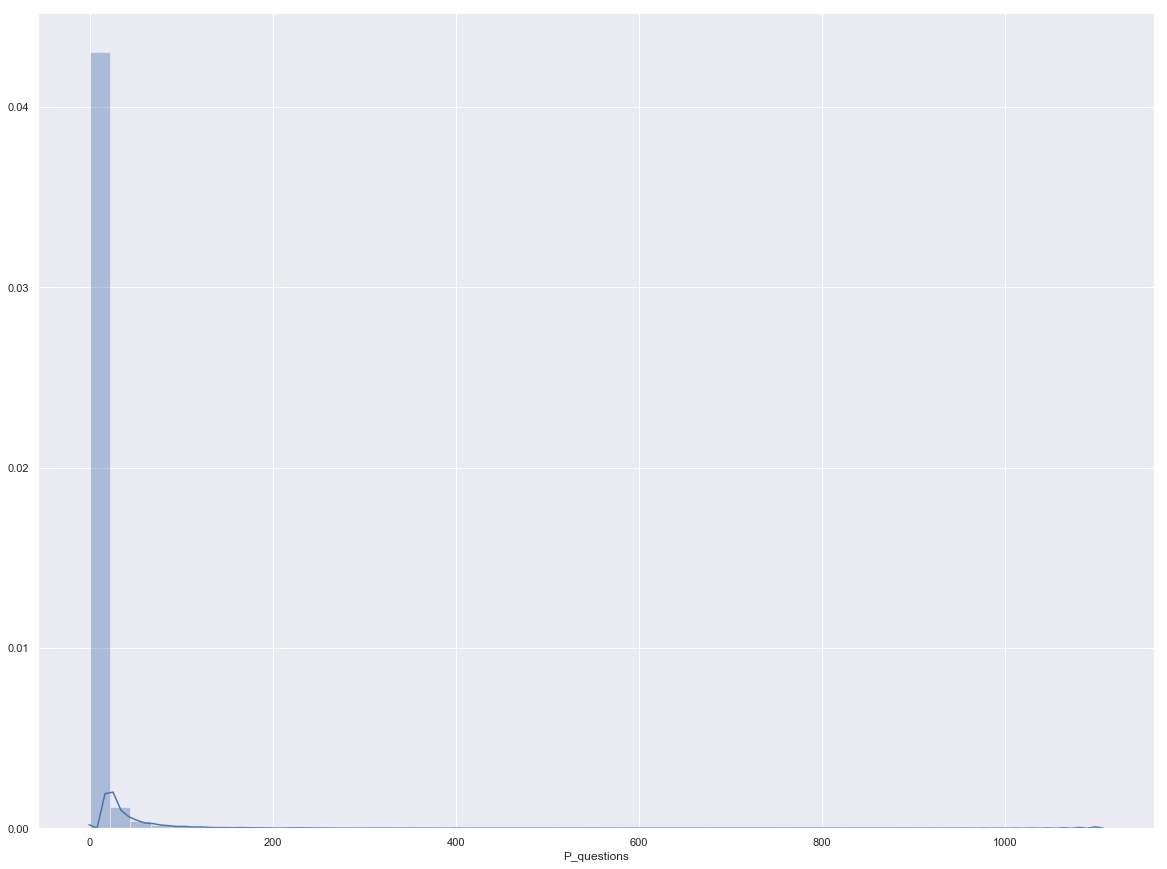

In [17]:
# ~ conversion error prevention **
# df_train = df_train.fillna(0)
# Seaborn 0_0
print('-'*100)
print('-'*100)
plt.figure(figsize=(20, 15))
sns.distplot(df_train['P_questions'].dropna());
# skewness and Kurtosis
print("Skewness: %f" % df_train['P_questions'].skew());
print("Kurtosis: %f" % df_train['P_questions'].kurt());
print('-'*100)
print('-'*100)
# ValueError: cannot convert float NaN to integer --- Error --- convertion is required ---> utilising fillna in early phase

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Skewness: 162.535179
Kurtosis: 35164.020362
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


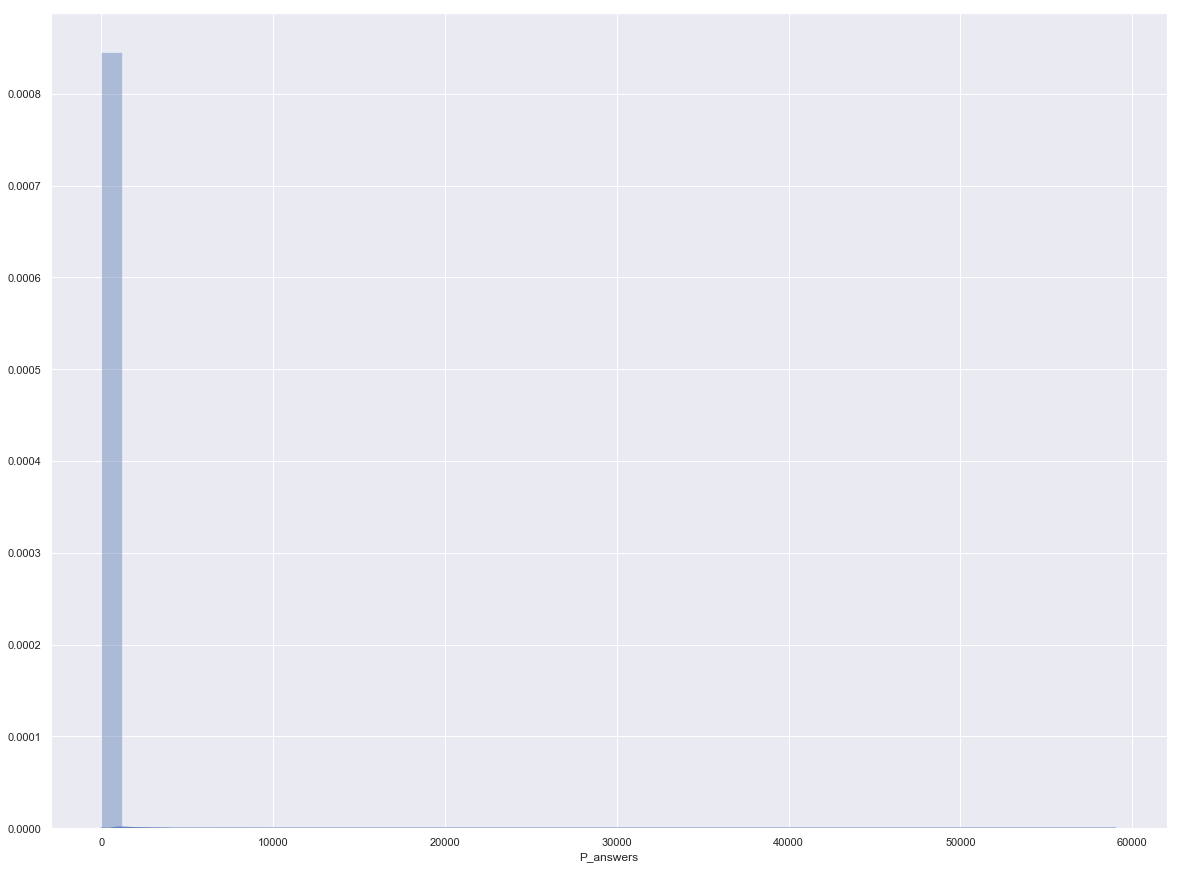

In [18]:
print('-'*100)
print('-'*100)
plt.figure(figsize=(20, 15))
sns.distplot(df_train['P_answers'].dropna());
# skewness and Kurtosis
print("Skewness: %f" % df_train['P_answers'].skew());
print("Kurtosis: %f" % df_train['P_answers'].kurt());
print('-'*100)
print('-'*100)

* As we can see, the target variable for both questions and answers is not normally distributed. 
* This behaviour can leads to performance reduction in the ML regression modeling due the fact that some models assume normal distribution.
* Therfore a log transformation is required(see sklearn info on preprocessing) to enhance distribution visualisation.

In [19]:
np.seterr(divide = 'ignore')
df_train['Questions_log'] = np.where(df_train.loc[:,['P_questions']]>0, np.log(df_train.loc[:,['P_questions']]), 0)
df_train['Answers_log'] = np.where(df_train.loc[:,['P_answers']]>0, np.log(df_train.loc[:,['P_answers']]), 0)


# # alternative implementation to avoids warnings.
# loc = np.where(myarray>0)
# result2 = np.zeros_like(myarray, dtype=float)
# result2[loc] =np.log(myarray[loc])

# # answer
# myarray= np.random.randint(10,size=10)
# result = np.where(myarray>0, np.log(myarray), 0)

# # check it is giving right solution:
# print(np.allclose(result, result2))

# append columns
# df_train = pd.concat([df_train, Questions_log], axis=1)

C:\Users\alamo248\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\alamo248\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
df_train.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,Questions_log,Answers_log
8441,6406742,usa,0.0,0.0,0,0,1,0,0,NaN,NaN,0.0,0.0,0.000000,0.000000
71219,402309,usa,65.0,76.8,12,0,71,54,11,6.0,3.0,12.0,3.0,2.484907,1.098612
91713,8745370,china,NaN,2.6,0,0,1,0,1,NaN,NaN,NaN,NaN,0.000000,0.000000
15695,8980446,usa,NaN,0.8,0,0,1,0,1,NaN,NaN,0.0,0.0,0.000000,0.000000
72968,974502,usa,0.0,80.9,7,0,333,13,6,NaN,NaN,0.0,17.0,0.000000,2.833213


----------------------------------------------------------------------------------------------------


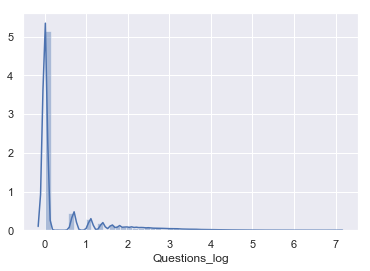

In [28]:
sns.distplot(df_train['Questions_log'].dropna());
print('-'*100)

----------------------------------------------------------------------------------------------------


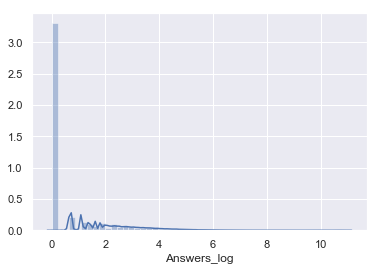

In [29]:
sns.distplot(df_train['Answers_log'].dropna());
print('-'*100)

In [ ]:
# Skewness and kurtosis for questions log
print("Skewness: %f" df_train['Questions_log'].skew());
print("Kurtosis: %f" df_train['Questions_log'].kurt());

In [ ]:
# Skewness and kurtosis for answers log
print("Skewness: %" df_train['Answers_log'].skew());
print("Kurtosis: %" df_train['Questions_log'].kurt());

In [23]:
# # create the independent variable vector
# x = df.iloc[:,6:15].values
# # Question dependent variable vector 
# y = df.iloc[:, -2:-1].values
# # Answer dependent variable vector 
# z = df.iloc[:,-1:].values
# # create labelEncoder object to transform categorical values into integers
# x[:, 0] = LabelEncoder().fit_transform(x[:, 0])
# y = LabelEncoder().fit_transform(y)
# z = LabelEncoder().fit_transform(z)
# # creating OneHotEncoder object to transform integer categorical values into dummy categorical
# x = OneHotEncoder(categorical_features=[0]).fit_transform(x).toarray()
# # Create training and testing sets
# x_train,x_test,y_train,y_test,z_train,z_test = train_test_split(x,y,z, test_size = 0.2, random_state = 0)
# # feature scaling
# sc_x = StandardScaler()
# x_train = sc_x.fit_transform(x_train)
# x_test = sc_x.transform(x_test)